In [1]:
# the Datacenter Computing team (alexghergh)

In [2]:
from datasets import load_dataset
import os
import torch
import torch.nn.functional as F
import torchvision
from tqdm.notebook import tqdm_notebook
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, LlamaConfig, LlamaForCausalLM
import multiprocessing as mp
import torch.distributed as dist

torch.set_printoptions(precision=5, sci_mode=False)

In [3]:
# make sure to run this on fep, using the ucsx queue
device = 'cuda'

## For this lab, we'll try to train the same model we used in the last laboratory, but in a distributed fashion. In short, distributed simply means "more than 1 GPU". Although there are multiple parallelism schemas, we'll only use **data parallelism** (DP) for now, to keep things simple.

## 1. The dataset, tokenizer, model, loss function, optimizer

We'll use the same settings from last time. Keep in mind, we want nothing more than to train the same model, on the same dataset, but in a **distributed** setup. Nothing changes, except the way the data is exchanged during training.

In [4]:
ds = load_dataset('roneneldan/tinystories')

In [5]:
ds['train'][0]

{'text': 'One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.'}

In [6]:
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")

In [7]:
context_length = 512

In [8]:
# tokenize and chunk the dataset into equal pieces
def tokenize_and_chunk(examples):
    outputs = tokenizer(
        examples['text'],
        truncation=True,
        max_length=context_length,
        return_overflowing_tokens=True,
        return_length=True,
    )
    input_batch = []
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == context_length:
            input_batch.append(input_ids)
    return {"input_ids": input_batch}

tokenized_ds = ds.map(
    tokenize_and_chunk, batched=True, remove_columns=ds["train"].column_names
)

In [9]:
# we need to set the format of the dataset to "torch", meaning we'll use pytorch tensors
tokenized_ds.set_format('torch')

In [10]:
# use the same llama example model as last time
config = LlamaConfig(vocab_size=len(tokenizer),
                     hidden_size=768,
                     intermediate_size=4*768,
                     num_hidden_layers=4,
                     num_attention_heads=16,
                     hidden_act='gelu_new',
                    )
model = LlamaForCausalLM(config)
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(50257, 768)
    (layers): ModuleList(
      (0-3): 4 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=768, out_features=768, bias=False)
          (k_proj): Linear(in_features=768, out_features=768, bias=False)
          (v_proj): Linear(in_features=768, out_features=768, bias=False)
          (o_proj): Linear(in_features=768, out_features=768, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=768, out_features=3072, bias=False)
          (up_proj): Linear(in_features=768, out_features=3072, bias=False)
          (down_proj): Linear(in_features=3072, out_features=768, bias=False)
          (act_fn): NewGELUActivation()
        )
        (input_layernorm): LlamaRMSNorm((768,), eps=1e-06)
        (post_attention_layernorm): LlamaRMSNorm((768,), eps=1e-06)
      )
    )
    (norm): L

In [11]:
sum(p.numel() for p in model.parameters()) - 2 * len(tokenizer) * 768

37755648

In [12]:
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn

CrossEntropyLoss()

In [13]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1, betas=(0.9, 0.95))
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.95)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    weight_decay: 0.1
)

## 2. The training loop

Nothing much changes here, except the synchronization of gradients. Notice the extra lines of code we used to do this.

There's one extra thing that comes with parallelism, and that is the _data_ in _data parallelism_. Specifically, we also now need to partition the data for each GPU. Instead of 1 GPU seeing all the data, now 2 GPUs see half of the data (this is why the overall process should be twice faster). To do this, we simply select a subset of the data from the whole dataset, based on the rank of the process.

In [14]:
def training_loop_fn(rank, world_size):

    # let's move the model to the proper GPU
    model.to(device + ':' + str(rank)) # string addition, should end up as 'cuda:0', 'cuda:1' etc.

    # partition the data; each worker/GPU gets its chunk of the data to work on,
    # based on its rank and the total number of workers (the world size)
    dataset_chunk_size = len(tokenized_ds['train']) // world_size
    dl = torch.utils.data.DataLoader(
        tokenized_ds['train'].select(range(rank * dataset_chunk_size, (rank + 1) * dataset_chunk_size)),
        batch_size=16,
        shuffle=False) # don't shuffle
    
    epochs = 1
    losses = []

    for epoch in range(epochs):

        # unfortunately, because this now runs in a separate process, tqdm cannot display a progress bar to
        # the main process; to make this work, extra work is needed to share the state with the main process
        # using something like pipes or shared memory; we'll skip this for now
        for batch in tqdm_notebook(dl, total=len(dl)):
            # retrieve one batch of data from the dataloader
            inputs = batch['input_ids']
    
            # move the inputs to GPU
            inputs = inputs.to(device + ':' + str(rank))
            
            labels = inputs
    
            # before anything else, make sure we have no gradients yet calculated/saved,
            # for any of the model parameters
            optimizer.zero_grad()
    
            # calculate the output of the model (we need the "logits" of the model, which
            # is what the output of the final linear layer is called)
            output = model(inputs).logits
            
            # we are doing next-token prediction, so we shift label scores and outputs by 1
            labels = labels[:, 1:].contiguous()
            shifted_output = output[:, :-1, :].contiguous()
    
            # calculate the loss (error) of the model with respect to the labels
            loss = loss_fn(shifted_output.view(-1, shifted_output.size(-1)), labels.view(-1))
    
            # save the loss value
            losses.append(loss.item())
    
            # this is where the magic happens; PyTorch now calculates the gradients AUTOMATICALLY for us,
            # and the optimizer updates the parameters with these gradients (only AFTER synchronizing them
            # with the rest of the workers)
            loss.backward()
    
            # here's the extra lines that synchronize the gradients across multiple workers, after
            # each worker calculated them in the backward pass
            # notice that this is the ONLY synchronization point of the workers; everything
            # else, after the initial setup, is done independently
            for param in model.parameters():
                dist.all_reduce(param.grad.data, op=dist.ReduceOp.SUM)
                param.grad.data /= world_size
    
            # only after averaging the gradients, we can update the parameters
            optimizer.step()

    # save the model at the end; as all ranks hold the same model, we only need to save it from rank 0
    if rank == 0:
        model.save_pretrained('lab5_pretrained_model')

    # let's also save the losses; only for first rank, because the rest should be the same
    if rank == 0:
        torch.save(losses, 'losses.pth')

## 3. Setting up multiple processes

Finally, here comes the fun part! We need to set up multiple processes, one for each data parallel worker (or a so-called *model replica*). These processes need to know about each other. One of them is the main node, which coordinates the communication, while other nodes (in our case only 1 other) are workers, which connect to the main node to initiate distributed training.

In order to exchange the gradients, we'll simply use All-Reduce operations (see [Pytorch's torch.distributed package](https://pytorch.org/docs/stable/distributed.html#torch.distributed.all_reduce)).

First of all, we need a way to initialize each process. This is the step which tells each GPU who to connect to, since we now have a group of processes to coordinate. For this, we'll simply write an `init_process` function, which receives the **rank** (i.e. GPU number inside the group of processes), the **world size** (the actual number of processes in the group), and the function to execute, after connecting to the main GPU (which will just be our training loop).

In [15]:
def init_process(rank, world_size, loop_fn):
    # initialize distributed environment, by telling each worker
    # where the master process can be found; since we know that
    # our GPUs are all connected to the same PC, we'll just give it
    # the localhost address, and a random port of our choosing
    os.environ['MASTER_ADDR'] = '127.0.0.1'
    os.environ['MASTER_PORT'] = '29500'

    # we'll use the NCCL backend (which is for Nvidia GPUs); if instead
    # you want to run this on CPU, using MPI, you can switch to 'gloo' as
    # backend
    dist.init_process_group(backend='nccl', rank=rank, world_size=world_size)

    # finally, launch the training loop
    loop_fn(rank, world_size)

Now, we need to actually start multiple processes. We'll just use the [multiprocessing](https://docs.python.org/3/library/multiprocessing.html) utility in python, using the _"spawn"_ method (which is simply using a syscall of `posix_spawn`, or `fork` + `exec` where that's not available).

In [16]:
# pick the number of GPUs here; run 'nvidia-smi' on fep to see how many you have available
world_size = 2
    
processes = []
#mp.set_start_method("spawn")

# each GPU in a "world" (i.e. group of processes) is assigned a rank; we start each process
# separately and tell it to connect to the main GPU (with rank 0) through the "init_process"
# function above
for rank in range(world_size):
    p = mp.Process(target=init_process, args=(rank, world_size, training_loop_fn))
    p.start()
    processes.append(p)

# finally, wait for all to finish
for p in processes:
    p.join()

## 4. Wrapping up (inference and loss visualization)

/tmp/ipykernel_1474945/3841630559.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  losses = torch.load('losses.pth')


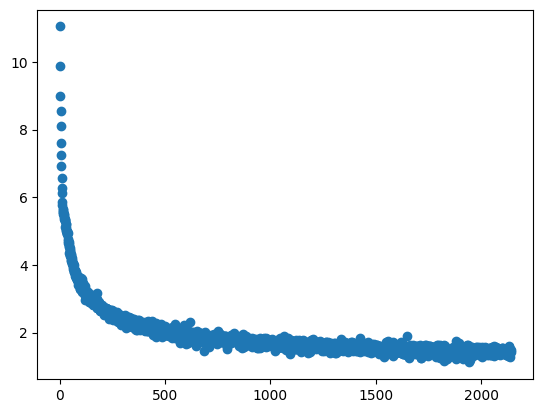

In [17]:
# and finally let's load the losses and the model back into our jupyter notebook;
# remember, we couldn't directly use them in the above training loop, because it
# runs in a different, fork'ed process
model = LlamaForCausalLM.from_pretrained('lab5_pretrained_model')
losses = torch.load('losses.pth')

plt.scatter(range(len(losses)), losses)

In [18]:
# try to play around with this prompt; see what the model can and can't do
text_to_complete = 'Lily said the color of the rainbow was very'

In [19]:
# inference on the model
from transformers import pipeline

pipe = pipeline('text-generation', model=model, tokenizer=tokenizer, device=device)
output = pipe(
    text_to_complete,
    max_new_tokens=256, # number of tokens to generate
    do_sample=True, # this gives us a little randomness; set to False for deterministic generation
)[0]['generated_text']

print(output)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Lily said the color of the rainbow was very happy. It was different from the sky that fell from the sky. Lily had seen her friends standing over the ground. They wore different shirts and had different colors.

"Look, Lily, I see a rainbow," Tim said. He held the rainbow tightly. He wanted to show it to his friends.

"Wow, Ben, that's a pretty rainbow!" Lily said. She wanted to show him Ben's sunflower.

"Look, I have a sunflower unicorn!" Ben said. He looked and waved his hand.

Lily smiled and ran to Ben. She was careful not to burn the rainbow. She held her sunflower tight.

"Look, Ben, I found a rainbow unicorn!" Lily said. She held out her hand. She wanted to touch it.

Ben was frightened. He did not like to stay in the rain. It was sad and dirty and cold. He ran to Lily and cried.

"Lily, come back!" Ben shouted.

Mom heard Ben. She ran to Ben. She saw him in the rain. She saw his wet hat bleeding, his green hat, his black dress, his green hat, and his orange face.

"Oh, Lily


## 5. Scaling up to infinity.. and beyond

As an exercise, try to do the same for more than 2 GPUs (e.g. for 3). What part of the code needs to change? What stays constant? If I scale up to 10k GPUs, or to 100k GPUs, using the same model, and just data parallelism, what changes? Try to think through these questions while going over the code.

Of course, using bigger models, where one model cannot fit into 1 GPU, necessitates different strategies, such as pipeline or tensor parallelism.

If you're curious about more, there's [an excellent tutorial from PyTorch on DP](https://pytorch.org/tutorials/intermediate/dist_tuto.html) explaining this communication step between multiple GPUs, a more advanced tutorial on [how to use Distributed Data Parallel in PyTorch](https://pytorch.org/tutorials/beginner/ddp_series_multigpu.html), which abstracts away some of the things we've done above, and there's [a more general tutorial](https://pytorch.org/tutorials/beginner/dist_overview.html) detailing more about what parallelism strategies there are (mainly pipeline and tensor parallelism in PyTorch), and how to use those together with DP.